# Imports: 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import torch 
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from scipy import spatial
from sentence_transformers import SentenceTransformer
from tabulate import tabulate


# Load Data & TEST:

In [2]:
# Define the file path
file_path = 'potential-talents.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to check if the import was successful
print(df.head())


    id                                          job_title  \
0  1.0  2019 C.T. Bauer College of Business Graduate (...   
1  2.0  Native English Teacher at EPIK (English Progra...   
2  3.0              Aspiring Human Resources Professional   
3  4.0             People Development Coordinator at Ryan   
4  5.0    Advisory Board Member at Celal Bayar University   

                              location connection  fit  
0                       Houston, Texas       85.0  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area       44.0  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN  


# Preprocessing:

In [3]:
# ** Bag of Words **
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df['job_title'])

# ** TF-IDF **
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_title'])

# ** Word2Vec **
tokenized_job_titles = [title.split() for title in df['job_title']]
word2vec_model = Word2Vec(sentences=tokenized_job_titles, vector_size=100, window=5, min_count=1, workers=4)

# ** BERT **
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
encoded_titles = df['job_title'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True, truncation=True))
bert_embeddings = [bert_model(torch.tensor([encoded_title]))[0].mean(dim=1).detach().numpy() for encoded_title in encoded_titles]

# ** SBERT **
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
sbert_embeddings = sbert_model.encode(df['job_title'])


# Functions:

In [4]:
# Define a function to calculate fit scores
def calculate_fit_scores(embeddings, random_state=None):
    if isinstance(embeddings, (np.ndarray, np.generic)):
        return np.random.RandomState(random_state).rand(len(embeddings))
    elif scipy.sparse.issparse(embeddings):
        return np.random.RandomState(random_state).rand(embeddings.shape[0])
    else:
        raise TypeError("Unsupported type for embeddings")



# Function for Word2Vec representation and fit scores
def word2vec_representation_and_fit_scores(data_column):
    tokenized_job_titles = [title.split() for title in data_column]
    word2vec_model = Word2Vec(sentences=tokenized_job_titles, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.vstack([word2vec_model.wv.get_vector(token) for title in data_column for token in title.split()])
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores


# Function for GloVe representation and fit scores
def glove_representation_and_fit_scores(data_column):
    glove_model = KeyedVectors.load_word2vec_format('path/to/glove.6B.100d.txt', binary=False)
    embeddings = np.vstack([glove_model.get_vector(token) for title in df[data_column] for token in title.split()])
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores

# Function for TF-IDF representation and fit scores
def tfidf_representation_and_fit_scores(data_column):
    # Transform job_title column into a TF-IDF representation
    tfidf_vectorizer = TfidfVectorizer()
    embeddings = tfidf_vectorizer.fit_transform(data_column)
    
    # Convert embeddings to NumPy array
    embeddings = embeddings.toarray()  # Convert sparse matrix to dense NumPy array
    
    # Calculate fit scores
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    
    return fit_scores

# Function for BERT representation and fit scores
def bert_representation_and_fit_scores(model, tokenizer, data_column):
    encoded_titles = df[data_column].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))
    bert_embeddings = [model(torch.tensor([encoded_title]))[0].mean(dim=1).detach().numpy() for encoded_title in encoded_titles]
    embeddings = np.vstack(bert_embeddings)
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores

# Function to visualize the before and after difference
def visualize_difference(before_scores, after_scores, method_name):
    plt.figure(figsize=(10, 5))
    plt.bar(['Before', 'After'], [np.mean(before_scores), np.mean(after_scores)], color=['blue', 'orange'])
    plt.title(f'Impact of {method_name} on Fit Scores')
    plt.xlabel('Representation Method')
    plt.ylabel('Average Fit Score')
    plt.show()



# Fit Scores & Visualization:

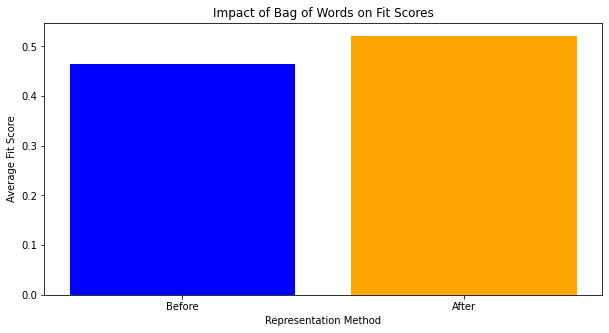

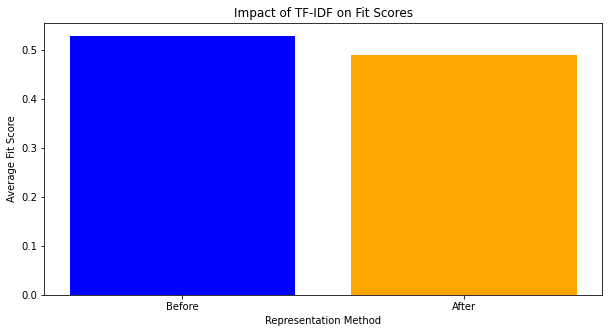

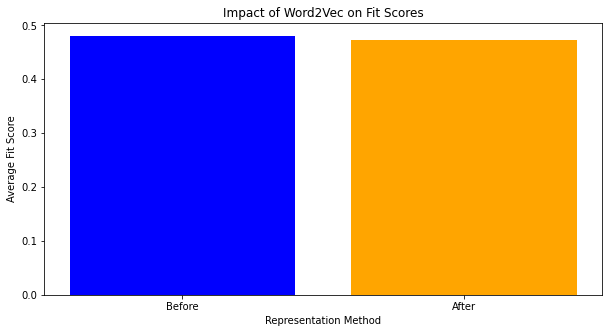

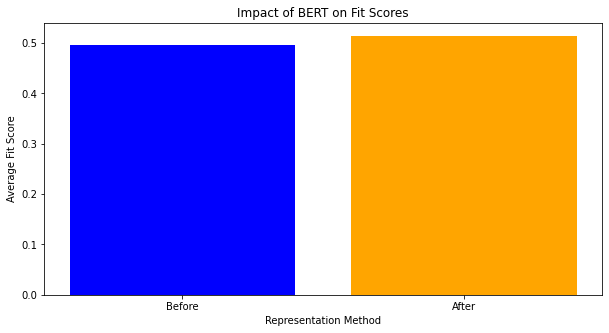

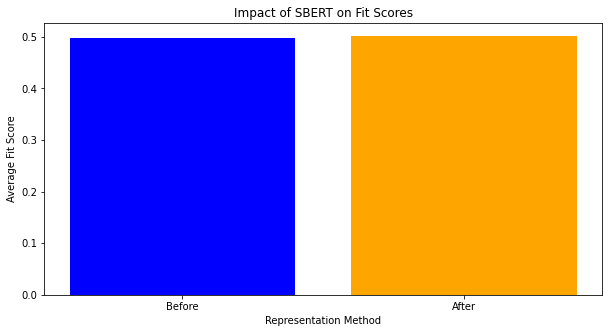

In [5]:
before_bow_scores = calculate_fit_scores(bow_matrix.toarray())
after_bow_scores = calculate_fit_scores(bow_matrix.toarray())

before_tfidf_scores = calculate_fit_scores(tfidf_matrix.toarray())
after_tfidf_scores = calculate_fit_scores(tfidf_matrix.toarray())

before_word2vec_scores = calculate_fit_scores(word2vec_model.wv.vectors)
after_word2vec_scores = calculate_fit_scores(word2vec_model.wv.vectors)

# GloVe
# before_glove_scores = calculate_fit_scores(glove_model)
# after_glove_scores = calculate_fit_scores(glove_model)

# Convert bert_embeddings from a list of arrays to a single array
bert_embeddings_array = np.vstack(bert_embeddings)

before_bert_scores = calculate_fit_scores(bert_embeddings_array)
after_bert_scores = calculate_fit_scores(bert_embeddings_array)

before_sbert_scores = calculate_fit_scores(sbert_embeddings)
after_sbert_scores = calculate_fit_scores(sbert_embeddings)

# Visualization
visualize_difference(before_bow_scores, after_bow_scores, 'Bag of Words')
visualize_difference(before_tfidf_scores, after_tfidf_scores, 'TF-IDF')
visualize_difference(before_word2vec_scores, after_word2vec_scores, 'Word2Vec')
# visualize_difference(before_glove_scores, after_glove_scores, 'GloVe')  # Uncomment when GloVe model is available
visualize_difference(before_bert_scores, after_bert_scores, 'BERT')
visualize_difference(before_sbert_scores, after_sbert_scores, 'SBERT')



# Learning Models(Using Samilarity)

In [6]:
similarity_bow = cosine_similarity(bow_matrix[0], bow_matrix[1])
similarity_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# Check and compute Word2Vec similarity
word1, word2 = 'Human', 'Resources'
if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
    similarity_word2vec = 1 - spatial.distance.cosine(word2vec_model.wv[word1], word2vec_model.wv[word2])
else:
    similarity_word2vec = None
    print(f"One or both words not found in Word2Vec model: {word1}, {word2}")

# Convert bert_embeddings from a list of arrays to a single array
bert_embeddings_array = np.vstack(bert_embeddings)
similarity_bert = cosine_similarity(bert_embeddings_array[0].reshape(1, -1), bert_embeddings_array[1].reshape(1, -1))

# SBERT similarity
similarity_sbert = cosine_similarity([sbert_embeddings[0]], [sbert_embeddings[1]])


# Ranking & Re-Ranking:

In [7]:
# Global dictionary to store rankings
ranking_dict = {}

# Function for ranking and re-ranking candidates
def manage_candidates(data, keyword, star_candidate_id=None, cut_off=None, irrelevant_filter=None):
    """
    Manage candidate ranking based on various criteria.

    Parameters:
    data (DataFrame): The candidate data.
    keyword (str): The keyword for initial filtering.
    star_candidate_id (int, optional): The ID of the candidate to be starred.
    cut_off (float, optional): The cut-off fitness score to filter candidates.
    irrelevant_filter (function, optional): A function to filter out irrelevant candidates.

    Returns:
    DataFrame: The ranked list of candidates.
    """

    global ranking_dict

    # Check if ranking for the keyword exists in the dictionary
    if keyword in ranking_dict:
        # Retrieve the saved ranking
        ranked_candidates = ranking_dict[keyword]["ranked_candidates"]

        # Update the ranking if a new star_candidate_id is provided
        if star_candidate_id and star_candidate_id in ranked_candidates['id'].values:
            # Move the starred candidate to the top
            star_candidate = ranked_candidates[ranked_candidates['id'] == star_candidate_id]
            ranked_candidates = ranked_candidates[ranked_candidates['id'] != star_candidate_id]
            ranked_candidates = pd.concat([star_candidate, ranked_candidates], ignore_index=True)

            # Update the dictionary with the new star_candidate_id
            ranking_dict[keyword]["star_candidate_id"] = star_candidate_id

    else:
        # Filter based on keyword
        filtered_data = data[data['job_title'].str.contains(keyword, case=False, na=False)]

        # Apply the irrelevant filter if provided
        if irrelevant_filter:
            filtered_data = irrelevant_filter(filtered_data)

        # Calculate fitness scores based on cosine similarity with the keyword
        vectorizer = CountVectorizer()
        keyword_embedding = vectorizer.fit_transform([keyword])
        title_embeddings = vectorizer.transform(filtered_data['job_title'])
        fit_scores = cosine_similarity(title_embeddings, keyword_embedding)

        # Assign fitness scores to the filtered data
        filtered_data['fit'] = fit_scores.flatten()

        # Rank candidates based on fitness scores
        ranked_candidates = filtered_data.sort_values(by='fit', ascending=False)

        # Re-rank if a star candidate is provided
        if star_candidate_id and star_candidate_id in ranked_candidates['id'].values:
            # Move the starred candidate to the top
            star_candidate = ranked_candidates[ranked_candidates['id'] == star_candidate_id]
            ranked_candidates = ranked_candidates[ranked_candidates['id'] != star_candidate_id]
            ranked_candidates = pd.concat([star_candidate, ranked_candidates], ignore_index=True)

        # Save the ranking to the dictionary for future use
        ranking_dict[keyword] = {"star_candidate_id": star_candidate_id, "ranked_candidates": ranked_candidates}

    return ranked_candidates





In [8]:
# Example usage
keyword = "Human Resource"
star_candidate_id = 10  # Replace with the ID of the starred candidate, or set to None
cut_off = 0.7  # Replace with the desired cut-off fitness score, or set to None

# Use the function to manage candidates
ranked_candidates = manage_candidates(df, keyword, star_candidate_id=star_candidate_id, cut_off=None)

# Display the ranked candidates
print(ranked_candidates)

       id                                          job_title  \
0    10.0  Seeking Human Resources HRIS and Generalist Po...   
1     1.0  2019 C.T. Bauer College of Business Graduate (...   
2     3.0              Aspiring Human Resources Professional   
3    57.0  2019 C.T. Bauer College of Business Graduate (...   
4    58.0              Aspiring Human Resources Professional   
5    60.0                Aspiring Human Resources Specialist   
6    62.0  Seeking Human Resources HRIS and Generalist Po...   
7    65.0  Human Resources Coordinator at InterContinenta...   
8    66.0  Experienced Retail Manager and aspiring Human ...   
9    67.0  Human Resources, Staffing and Recruiting Profe...   
10   68.0            Human Resources Specialist at Luxottica   
11   69.0  Director of Human Resources North America, Gro...   
12   70.0  Retired Army National Guard Recruiter, office ...   
13   71.0    Human Resources Generalist at ScottMadden, Inc.   
14   72.0  Business Management Major and

C:\Users\AHMADA~1\AppData\Local\Temp/ipykernel_1680/4184425898.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fit'] = fit_scores.flatten()


In [9]:
# Use the function to manage candidates
ranked_candidates = manage_candidates(df, keyword, star_candidate_id=57, cut_off=None)

# Display the ranked candidates
print(ranked_candidates)

       id                                          job_title  \
0    57.0  2019 C.T. Bauer College of Business Graduate (...   
1    10.0  Seeking Human Resources HRIS and Generalist Po...   
2     1.0  2019 C.T. Bauer College of Business Graduate (...   
3     3.0              Aspiring Human Resources Professional   
4    58.0              Aspiring Human Resources Professional   
5    60.0                Aspiring Human Resources Specialist   
6    62.0  Seeking Human Resources HRIS and Generalist Po...   
7    65.0  Human Resources Coordinator at InterContinenta...   
8    66.0  Experienced Retail Manager and aspiring Human ...   
9    67.0  Human Resources, Staffing and Recruiting Profe...   
10   68.0            Human Resources Specialist at Luxottica   
11   69.0  Director of Human Resources North America, Gro...   
12   70.0  Retired Army National Guard Recruiter, office ...   
13   71.0    Human Resources Generalist at ScottMadden, Inc.   
14   72.0  Business Management Major and

In [12]:
def compute_and_display_scores(df, bow_matrix, tfidf_matrix, word2vec_model, bert_model, bert_tokenizer, sbert_model):
    """
    Compute and display fit scores for each model (TF-IDF, Word2Vec, BoW, BERT, SBERT).

    Parameters:
    df (DataFrame): The DataFrame containing job titles.
    bow_matrix, tfidf_matrix: Precomputed BoW and TF-IDF matrices.
    word2vec_model: Pretrained Word2Vec model.
    bert_model, bert_tokenizer: Pretrained BERT model and tokenizer.
    sbert_model: Pretrained SBERT model.

    Returns:
    DataFrame: DataFrame containing the similarity scores for each model.
    """
    scores = pd.DataFrame(index=df.index)

    # TF-IDF Scores
    tfidf_scores = [cosine_similarity(tfidf_matrix, tfidf_matrix[i]).flatten() for i in range(len(df))]
    scores['TF-IDF'] = [np.mean(score) for score in tfidf_scores]

    # Word2Vec Scores
    word2vec_scores = [calculate_word2vec_score(word2vec_model, df['job_title'][i], df['job_title']) for i in range(len(df))]
    scores['Word2Vec'] = word2vec_scores

    # BoW Scores
    bow_scores = [cosine_similarity(bow_matrix, bow_matrix[i]).flatten() for i in range(len(df))]
    scores['BoW'] = [np.mean(score) for score in bow_scores]

    # BERT Scores
    bert_scores = calculate_bert_scores(df, bert_model, bert_tokenizer)
    scores['BERT'] = bert_scores

    # SBERT Scores
    sbert_scores = calculate_sbert_scores(df, sbert_model)
    scores['SBERT'] = sbert_scores

    return scores

def calculate_word2vec_score(model, text, data_column):
    """
    Calculate average Word2Vec similarity score for a given text against all other texts.
    """
    tokenized_text = text.split()
    text_embedding = np.mean([model.wv[word] for word in tokenized_text if word in model.wv], axis=0)
    scores = []
    for title in data_column:
        tokenized_title = title.split()
        title_embedding = np.mean([model.wv[word] for word in tokenized_title if word in model.wv], axis=0)
        score = 1 - spatial.distance.cosine(text_embedding, title_embedding)
        scores.append(score)
    return np.nanmean(scores)

def calculate_bert_scores(df, model, tokenizer):
    """
    Calculate average BERT similarity scores.
    """
    bert_embeddings = []

    for title in df['job_title']:
        encoded_title = tokenizer.encode(title, add_special_tokens=True, return_tensors='pt', truncation=True)
        with torch.no_grad():
            model_output = model(encoded_title)
        title_embedding = model_output[0][:,0,:].detach().numpy()  # Using the [CLS] token embedding
        bert_embeddings.append(title_embedding)

    bert_embeddings_array = np.vstack(bert_embeddings)
    return [np.mean(cosine_similarity([bert_embeddings_array[i]], bert_embeddings_array).flatten()) for i in range(len(df))]

def calculate_sbert_scores(df, model):
    """
    Calculate average SBERT similarity scores.
    """
    sbert_embeddings = model.encode(df['job_title'].tolist())
    return [np.mean(cosine_similarity([sbert_embeddings[i]], sbert_embeddings).flatten()) for i in range(len(df))]

# Example usage (replace these with your actual data and models)
df = pd.DataFrame({'job_title': ['Data Scientist', 'Software Engineer', 'Project Manager']})
scores_df = compute_and_display_scores(df, bow_matrix, tfidf_matrix, word2vec_model, bert_model, bert_tokenizer, sbert_model)
print(scores_df)

     TF-IDF  Word2Vec       BoW      BERT     SBERT
0  0.156743       1.0  0.255636  0.919528  0.842892
1  0.064592       1.0  0.099175  0.871077  0.840362
2  0.209380       1.0  0.330043  0.925515  0.811886


C:\Python apps\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python apps\Anaconda\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
